# Minimal example in pyro

## Debug

In [1]:
# may need development version of pyro
# when running on python 3.10
# see: https://github.com/pyro-ppl/pyro/pull/3101
# !sudo pip install git+https://github.com/pyro-ppl/pyro.git

In [2]:
# # importing os module 
# import os
# import pprint
  
# # Get the list of user's
# # environment variables
# env_var = os.environ
  
# # Print the list of user's
# # environment variables
# print("User's Environment variable:")
# pprint.pprint(dict(env_var), width = 1)

In [ ]:
# %%bash

# which python
# python --version
# echo ${PATH}
# echo ${LD_LIBRARY_PATH}

In [4]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Setup

In [5]:
USE_CUDA = False
TORCH_DETERMINISTIC = True

### Import libraries

In [6]:
import os

In [7]:
if TORCH_DETERMINISTIC:
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    print(os.environ["CUBLAS_WORKSPACE_CONFIG"])

:4096:8


In [8]:
from inspect import getmembers
from pprint import pprint
from types import FunctionType

import arviz as az
import numpy as np
import torch

In [9]:
torch.use_deterministic_algorithms(TORCH_DETERMINISTIC)

In [10]:
SEED = 1234

In [11]:
np.random.seed(seed=SEED);
torch.manual_seed(SEED);

In [12]:
import pyro
import pyro.distributions as dist

from pyro.infer import MCMC, NUTS, Predictive
import platform

In [13]:
print(pyro.settings.get())

{'binomial_approx_log_prob_tol': 0.0, 'binomial_approx_sample_thresh': inf, 'cholesky_relative_jitter': 4.0, 'module_local_params': False, 'validate_distributions_pyro': True, 'validate_distributions_torch': True, 'validate_infer': True, 'validate_poutine': True}


In [14]:
print(platform.python_version())
print(pyro.__version__)
print(torch.__version__)
print(az.__version__)

3.10.9
1.8.4+9ed468d
1.13.1.post200
0.14.0


In [15]:
if not USE_CUDA:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


### Setup plotting

In [17]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [18]:
fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
# fonts_path = "/usr/share/fonts/OTF/"  # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [19]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [20]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

### Utility functions

In [21]:
def attributes(obj):
    disallowed_names = {
        name for name, value in getmembers(type(obj)) if isinstance(value, FunctionType)
    }
    return {
        name: getattr(obj, name)
        for name in dir(obj)
        if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
    }


def print_attributes(obj):
    pprint(attributes(obj))

## Execute

### Define sample data

In [22]:
N_obs = 100

In [23]:
# device=torch.device("cpu")
# observations = dist.Normal(0, 1).sample([N_obs])
observations = torch.randn(
    N_obs, 
    # names=(None,),
    # device=device,
)

In [24]:
observations

tensor([-0.1117, -0.4966,  0.1631, -0.8817,  0.0539,  0.6684, -0.0597, -0.4675,
        -0.2153,  0.8840, -0.7584, -0.3689, -0.3424, -1.4020,  0.3206, -1.0219,
         0.7988, -0.0923, -0.7049, -1.6024,  0.2891,  0.4899, -0.3853, -0.7120,
        -0.1706, -1.4594,  0.2207,  0.2463, -1.3248,  0.6970, -0.6631,  1.2158,
        -1.4949,  0.8810, -1.1786, -0.9340, -0.5675, -0.2772, -2.1834,  0.3668,
         0.9380,  0.0078, -0.3139, -1.1567,  1.8409, -1.0174,  1.2192,  0.1601,
         1.5985, -0.0469, -1.5270, -2.0143, -1.5173,  0.3877, -1.1849,  0.6897,
         1.3232,  1.8169,  0.6808,  0.7244,  0.0323, -1.6593, -1.8773,  0.7372,
         0.9257,  0.9247,  0.1825, -0.0737,  0.3147, -1.0369,  0.2100,  0.6144,
         0.0628, -0.3297, -1.7970,  0.8728,  0.7670, -0.1138, -0.9428,  0.7540,
         0.1407, -0.6937, -0.6159, -0.7295,  1.3204,  1.5997, -1.0792, -0.3396,
        -1.4538, -2.6740,  1.5984,  0.8021,  0.5722,  0.0653, -0.0235,  0.8876,
         1.4689,  1.2647, -0.2753, -0.13

### Define model

In [25]:
def model(obs=None):
    mu = pyro.sample("mu", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.HalfNormal(1))
    with pyro.plate("N_obs", N_obs):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=obs)

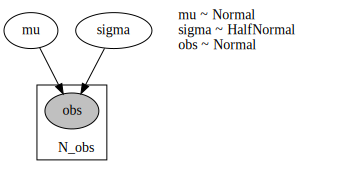

In [26]:
pyro.render_model(
    model, 
    model_args=(observations,), 
    render_distributions=True, 
    render_params=True,
)

### Fit model

In [27]:
R = 1000

In [28]:
prior_predictive = Predictive(model, num_samples=500)
prior_predictions = prior_predictive()

In [28]:
kernel = NUTS(model, jit_compile=False)

In [29]:
mcmc = MCMC(
    kernel, 
    warmup_steps=500, 
    num_samples=R, 
    num_chains=4, 
    # mp_context="spawn"
)

Warmup [1]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1500 [00:00, ?it/s]

In [30]:
mcmc.run(observations)

In [31]:
posterior_samples = mcmc.get_samples(group_by_chain=False)

In [32]:
posterior_predictive = Predictive(model, posterior_samples)
posterior_predictions = posterior_predictive()

In [33]:
[v.shape for k, v in posterior_predictions.items()]

[torch.Size([4000, 100])]

In [34]:
prior_predictive = Predictive(model, num_samples=500)
prior_predictions = prior_predictive()

In [35]:
[v.shape for k, v in prior_predictions.items()]

[torch.Size([500, 1]), torch.Size([500, 1]), torch.Size([500, 100])]

### Organize output data

In [36]:
data = az.from_pyro(
    mcmc,
    prior=prior_predictions,
    posterior_predictive=posterior_predictions,
)

In [37]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Evaluate model

#### Plot autocorrelation to evaluate MCMC chain mixing

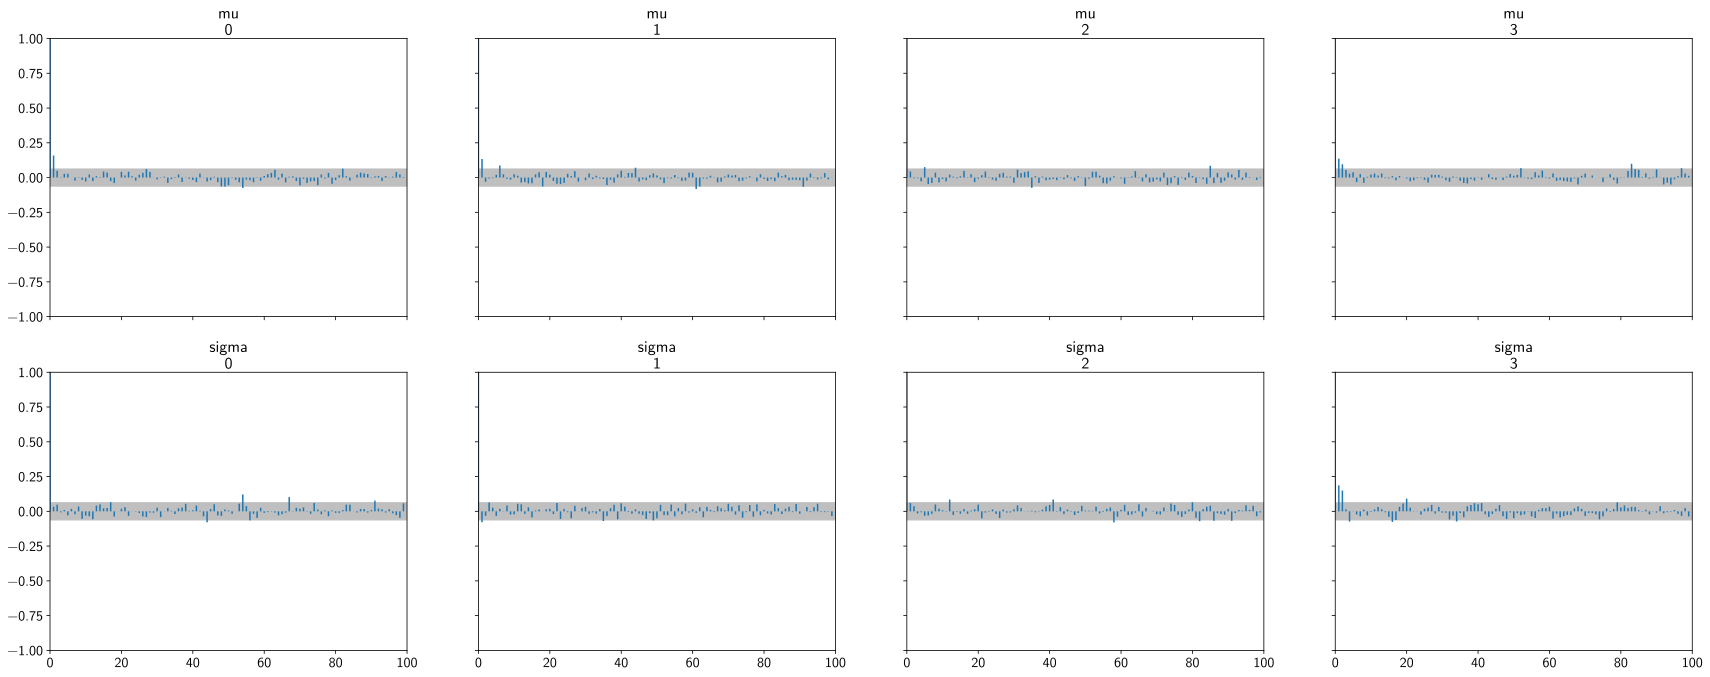

In [45]:
az.plot_autocorr(data, var_names=["mu", "sigma"]);

#### Plot prior and posterior predictive distributions

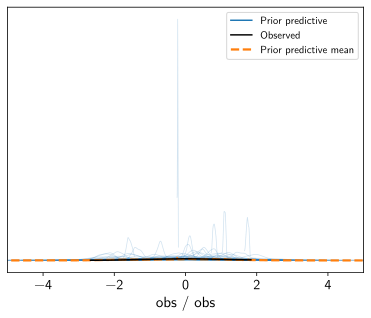

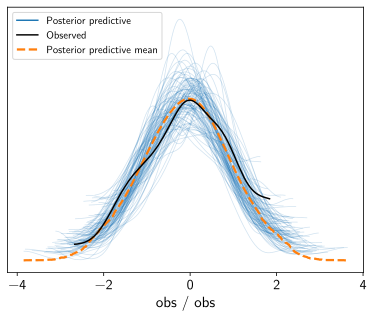

In [40]:
ax_pr_pred = az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
)
ax_pr_pred.set_xlim([-5, 5])
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
);

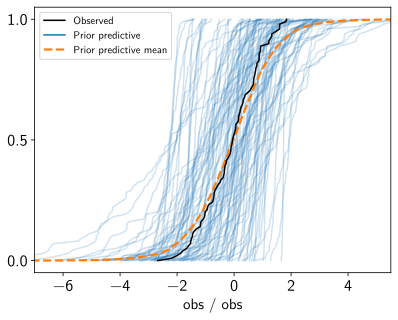

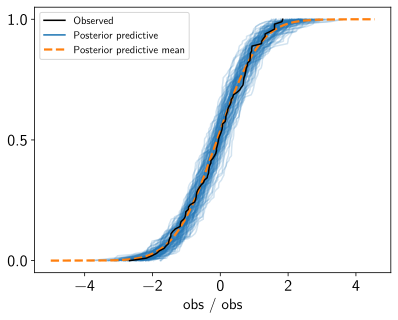

In [39]:
ax_pr_pred_cum = az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
)
ax_pr_pred_cum.set_xlim([-7, 5.5])
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
);

#### Characterize posterior distribution

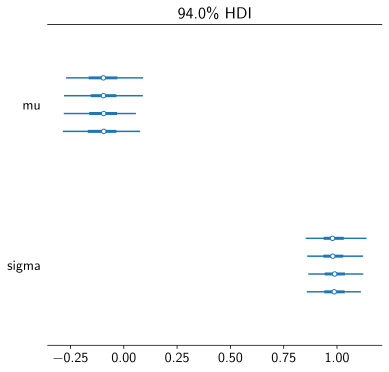

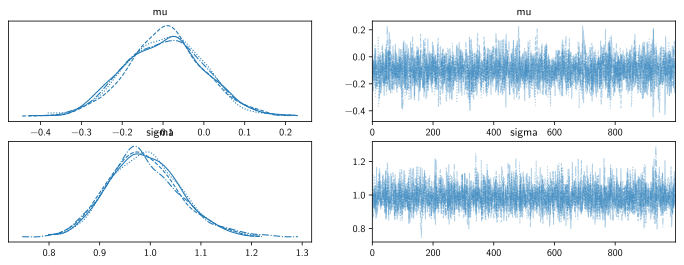

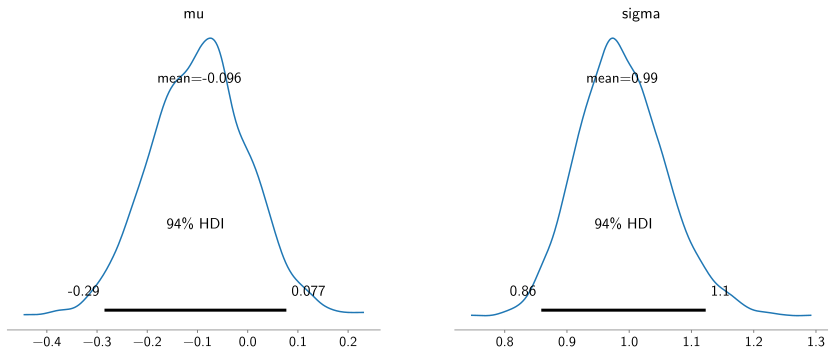

In [46]:
az.plot_forest(data);
az.plot_trace(data);
az.plot_posterior(data);